<a href="https://colab.research.google.com/github/vanle2000/Titanic/blob/main/Titanic_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import seaborn as sns 
%pylab inline 
import re 
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


# 1. Data preprocessing

## 1.1. Importing Data

In [22]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 1.2. Handing Missing Values:

In [23]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [25]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Dropping the `Cabin` column, since there is 687 missing values.

In [26]:
train.drop('Cabin', axis=1, inplace=True)
train.drop('PassengerId', axis=1, inplace=True)

# Applying the same thing to test set
test.drop('Cabin', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)

Next, using `Imputation` technique to treat `Age` and `Embarked` columns with the purpose to fill in missing values with estimated values based on available data. There are mulitple methods for imputing missing data, including:


*   Mean or median imputation: involves filling in missing values with `mean` or `median` value of the variable.
*   Mode imputation: involves filling in missing values with the most common value (`mode`) of the variable.
*   Regression imputation: involves predicting the missing values using `regression` based on the other variables of the dataset. 
*   K-nearest neighbor imputation: involves finding the `k-nearest neighbors` to the observation with missing values and filling in the missing values with the average of those neighbors.
*   Multiple imputation: involves generating multiple imputed datasets by creating pausible values for the missing values based on `statistical models`, and using these datasets to estimate parameters and make predictions. 


Imputing the `Age` column with the `median` value

In [27]:
train['Age'].fillna(train['Age'].median(), inplace=True)

Imputing the `Embrarked` column with the mode value

In [28]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

Checking for missing values to confirm all missing values in training set have been handled.

In [29]:
train.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [34]:
test['Age'].fillna(test['Age'].median(), inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)
test.isnull().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        1
Embarked    0
dtype: int64

## 1.3. Encoding Categorical Variables
There are various method to encode the categorical variables, in this Titanic dataset, we will work with `one-hot encoding` and `leave one out encoding (LOOE)`. 


One-hot encoding

In [12]:
cat_vars = ['Sex', 'Embarked']

# Perform one-hot encoding
encoder = ce.OneHotEncoder(cols=cat_vars,
                           handle_unknown='return_nan',
                           return_df=True,
                           use_cat_names=True)

train = encoder.fit_transform(train)

Leave one out encoding 

In [13]:
#Passing value 0.1 at sigma parameter to introduce noise
loo_encoder = ce.LeaveOneOutEncoder(cols=['Pclass'], sigma = 0.1)

loo_res = loo_encoder.fit_transform(train['Pclass'], train['Survived']).rename(columns = {'Pclass': 'loo_pclass'})
train = pd.concat([loo_res, train], axis =1).sample(5)

In [14]:
train.head(5)

,loo_pclass,Survived,Pclass,Name,Sex_male,Sex_female,Age,SibSp,Parch,Ticket,Fare,Embarked_S,Embarked_C,Embarked_Q
763,0.634422,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",0.0,1.0,36.0,1,2,113760,120.0000,1.0,0.0,0.0
383,0.697465,1,1,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",0.0,1.0,35.0,1,0,113789,52.0000,1.0,0.0,0.0
828,0.274919,1,3,"McCormack, Mr. Thomas Joseph",1.0,0.0,28.0,0,0,367228,7.7500,0.0,0.0,1.0
687,0.236076,0,3,"Dakic, Mr. Branko",1.0,0.0,19.0,0,0,349228,10.1708,1.0,0.0,0.0
538,0.217771,0,3,"Risien, Mr. Samuel Beard",1.0,0.0,28.0,0,0,364498,14.5000,1.0,0.0,0.0


Apply the same encoders to the test data

In [36]:
#Passing value 0.1 at sigma parameter to introduce noise
# loo_encoder = ce.LeaveOneOutEncoder(cols=['Pclass'], sigma = 0.1)

# test_encoded = loo_encoder.transform(test['Pclass']).rename(columns = {'Pclass': 'loo_pclass'})
# test = pd.concat([test, test_encoded], axis =1)

In [37]:
# train.describe()

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

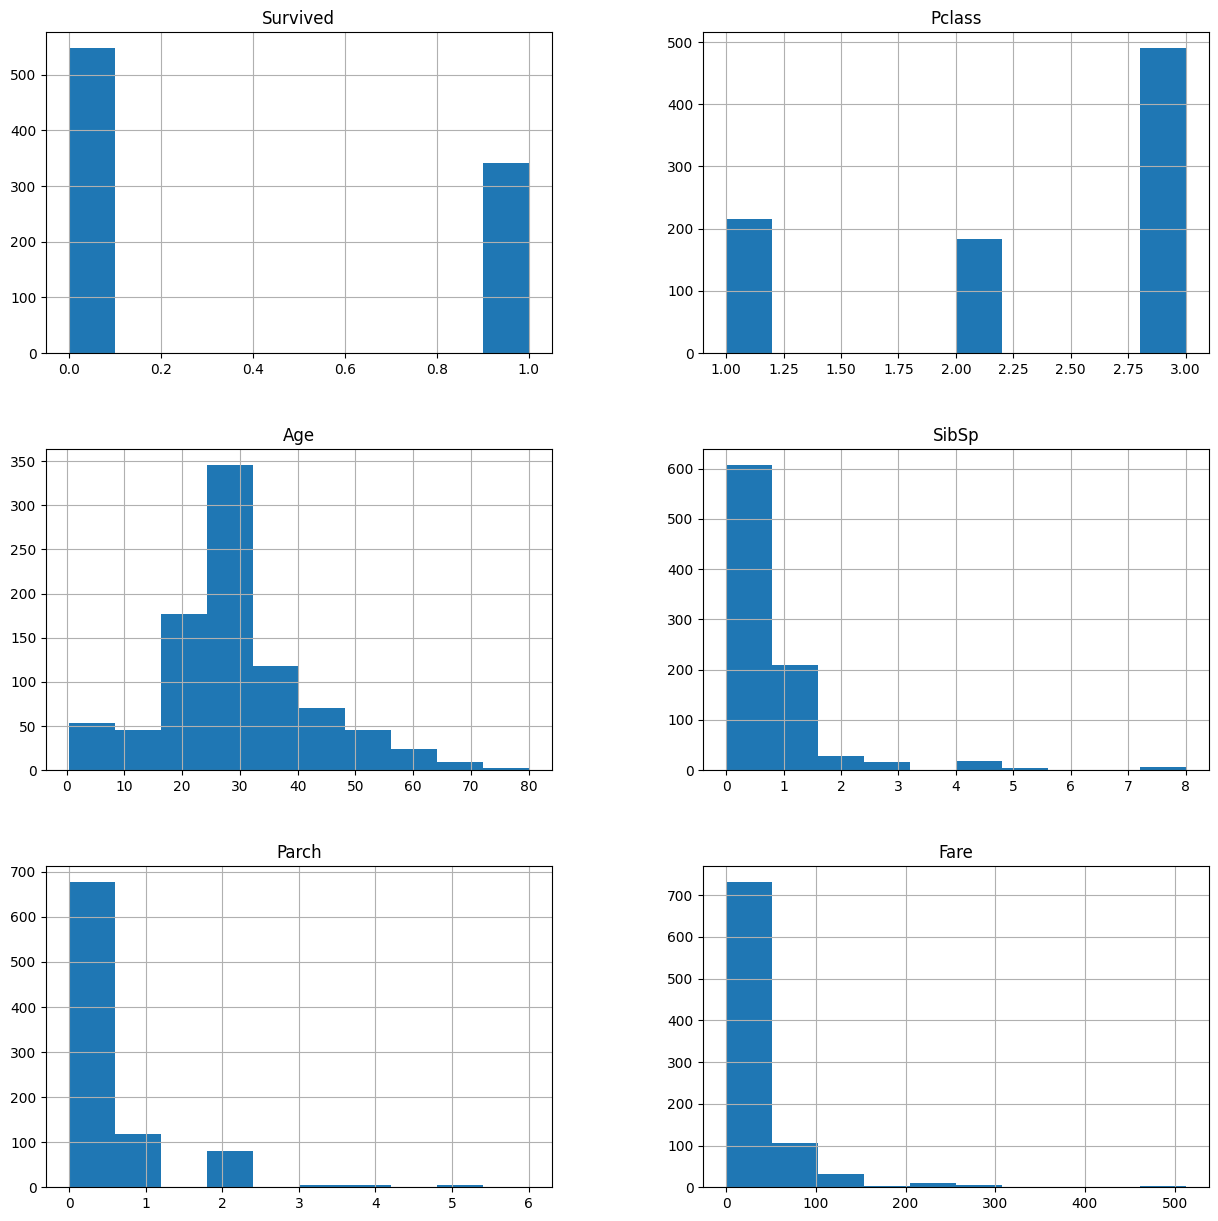

In [39]:
train.hist(figsize=(15,15))

## 1.4. Feature Engineering

In [47]:
def missing_value(colName):
  print(str(train[colName].isnull().sum()) + " null values out of " + str(len(train)) + " in training data.")
  print(str(test[colName].isnull().sum()) + " null values out of " + str(len(test)) + " in test data.")

### Name: Title Extraction

In [48]:
# Title Extraction
def extract_title(Name):
  title_pattern = r", \s*([^\.]*)\."
  return re.search(title_pattern, Name).group(1)

# Split the title from the Titanic dataset
for dataset in titanic_df:
  dataset['Title'] = dataset['Name'].apply(extract_title)

In [49]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [44]:
train['Title'].value_counts()

KeyError: ignored

In [45]:
# Recategorize title 
for dataset in titanic_df:
  dataset['Title'] = dataset['Title'].replace( ['Jonkheer', 'Don', 'Sir', 'Capt', 'Col', 'Major', 'Rev', 'Dr'], 'Mr')
  dataset['Title'] = dataset['Title'].replace( ['Mme', 'the Countess'], 'Mrs')
  dataset['Title'] = dataset['Title'].replace( ['Lady', 'Ms', 'Mlle'], 'Miss')

In [46]:
train['Title'].value_counts()

KeyError: ignored

### Define Family relationship

In [ ]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)